# Developing an AI application

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader

from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

import json
import time

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
#Define transforms
data_transforms = {}

# Define your transforms for the training
data_transforms['train'] = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])


# Define your transforms for the validation
data_transforms['valid'] = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])


# Define your transforms for the test
data_transforms['test'] = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])


# Load the datasets with ImageFolder
image_datasets = {}
image_datasets['train_data'] = datasets.ImageFolder(data_dir + '/train', transform=data_transforms['train'])
image_datasets['valid_data'] = datasets.ImageFolder(data_dir + '/valid', transform=data_transforms['valid'])
image_datasets['test_data'] = datasets.ImageFolder(data_dir + '/test', transform=data_transforms['test'])

# Using the image datasets and the transforms, define the dataloaders
dataloaders = {}
dataloaders['train_data'] = DataLoader(image_datasets['train_data'], batch_size=64, shuffle=True)
dataloaders['valid_data'] = DataLoader(image_datasets['valid_data'], batch_size=32, shuffle=False)
dataloaders['test_data'] = DataLoader(image_datasets['test_data'], batch_size=32, shuffle=False)

print(f"Train data: {len(dataloaders['train_data'].dataset)} images / {len(dataloaders['train_data'])} batches")
print(f"Valid data: {len(dataloaders['valid_data'].dataset)} images / {len(dataloaders['valid_data'])} batches")
print(f"Test  data: {len(dataloaders['test_data'].dataset)} images / {len(dataloaders['test_data'])} batches")

Train data: 6552 images / 103 batches
Valid data: 818 images / 26 batches
Test  data: 819 images / 26 batches


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [5]:
# Build and train your network using pre-trained network
model = models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 55441816.38it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [6]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

    
classifier = nn.Sequential  (OrderedDict ([
                            ('fc1', nn.Linear (2048, 1000)),
                            ('relu1', nn.ReLU ()),
                            ('dropout1', nn.Dropout (p = 0.5)),
                            ('fc2', nn.Linear (1000, 500)),
                            ('relu2', nn.ReLU ()),
                            ('dropout2', nn.Dropout (p = 0.5)),
                            ('fc3', nn.Linear (500, 102)),
                            ('output', nn.LogSoftmax (dim =1))
                            ]))

# Replacing the pretrained classifier with the one above
model.classifier = classifier
model.fc = classifier

    
# Recommended to use NLLLoss when using Softmax
criterion = nn.NLLLoss()

# Using Adam optimiser which makes use of momentum to avoid local minima
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [7]:
# check if CUDA is available
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Running on: {str(device).upper()}')

Running on: CUDA


In [8]:
# Train the network
start_time = time.time()

epochs = 3
print_every = 10

train_losses = []
validation_losses = []
validation_correct = []
total_train_data = len(dataloaders['train_data'])
total_validation_data = len(dataloaders['valid_data'])

    
# change to cpu/gpu mode
model.to(device)

for i in range(epochs):
    trn_corr = 0
    vld_corr = 0
    
    # Run the training batches
    for b, (inputs, labels) in enumerate(dataloaders['train_data']):
        b+=1
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Apply the model
        outputs = model(inputs)
        loss = criterion(outputs, labels)
 
        # Tally the number of correct predictions
        predicted = torch.max(outputs.data, 1)[1]
        batch_corr = (predicted == labels).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%print_every == 0:
            print(f'epoch: {i:2}  train batch: {b:4} loss: {loss.item():10.8f}')

    train_losses.append(loss)

    # Run the validation batches
    with torch.no_grad():
        for b, (inputs, labels) in enumerate(dataloaders['valid_data']):
                  
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply the model
            y_val = model(inputs)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            vld_corr += (predicted == labels).sum()
            loss = criterion(y_val, labels)
            
            # Print interim results
            if b%print_every == 0:
                print(f'epoch: {i:2}  validation batch: {b:4} loss: {loss.item():10.8f}  \
accuracy: {vld_corr.item()*100/(10*(b+1)):7.3f}%')
            
            
    validation_losses.append(loss)
    validation_correct.append(vld_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed


epoch:  0  train batch:   10 loss: 4.63311577
epoch:  0  train batch:   20 loss: 4.43980217
epoch:  0  train batch:   30 loss: 4.45847511
epoch:  0  train batch:   40 loss: 4.42236042
epoch:  0  train batch:   50 loss: 4.39465141
epoch:  0  train batch:   60 loss: 4.05905771
epoch:  0  train batch:   70 loss: 3.64908743
epoch:  0  train batch:   80 loss: 4.06712055
epoch:  0  train batch:   90 loss: 3.58210158
epoch:  0  train batch:  100 loss: 3.47286654
epoch:  0  validation batch:    0 loss: 4.84697151  accuracy:   0.000%
epoch:  0  validation batch:   10 loss: 4.41549015  accuracy:  27.273%
epoch:  0  validation batch:   20 loss: 3.75855565  accuracy:  35.238%
epoch:  1  train batch:   10 loss: 3.32097530
epoch:  1  train batch:   20 loss: 2.34857774
epoch:  1  train batch:   30 loss: 2.77190232
epoch:  1  train batch:   40 loss: 2.29546785
epoch:  1  train batch:   50 loss: 2.87359953
epoch:  1  train batch:   60 loss: 2.38831663
epoch:  1  train batch:   70 loss: 2.22775769
epoch

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [9]:
# Do validation on the test set
tst_corr = 0
tst_total = 0

# Run the test batches
with torch.no_grad():
    for b, (inputs, labels) in enumerate(dataloaders['test_data']):
        inputs, labels = inputs.to(device), labels.to(device)

        # Apply the model
        y_val = model(inputs)

        # Tally the number of correct predictions
        predicted = torch.max(y_val.data, 1)[1] 
        tst_corr += (predicted == labels).sum()
        tst_total += labels.size (0)
        loss = criterion(y_val, labels)
        
        # Print interim results
        if b%print_every == 0:
            print(f'Test batch: {b:4} loss: {loss.item():10.8f}  accuracy: {tst_corr.item()*100/(10*(b+1)):7.3f}%')
            

Test batch:    0 loss: 2.93922162  accuracy:  70.000%
Test batch:   10 loss: 4.12952375  accuracy:  66.364%
Test batch:   20 loss: 3.55524826  accuracy:  72.381%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [11]:
# Save the checkpoint 
# feature weights, classifier, class_to_idx mapping
checkpoint = {'state_dict': model.state_dict(),
              'classifier': model.classifier,
              'class_to_idx': image_datasets['train_data'].class_to_idx}

torch.save(checkpoint, 'flower-image-classifier-checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [12]:
# a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    
    # Checkpoint for when using GPU
    checkpoint = torch.load(filepath)
    
    
    model.load_state_dict(checkpoint['state_dict'])
    model.classifier = checkpoint['classifier'] 
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

# Loading model
model = load_checkpoint('flower-image-classifier-checkpoint.pth')

# Checking model i.e. should have 102 output units in the classifier
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [16]:
def process_image(image):
    
    # Process a PIL image for use in a PyTorch model
    image = F.resize(image, 224)
    
    upper_pixel = (image.height - 224) // 2
    left_pixel = (image.width - 224) // 2
    image = F.crop(image, upper_pixel, left_pixel, 224, 224)
    
    image = F.to_tensor(image)
    image = F.normalize(image, np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225]))
    
    return image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [17]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

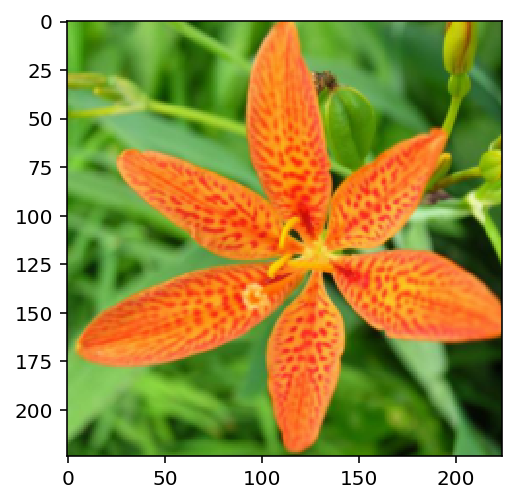

In [18]:
# Test image
image_name = data_dir + '/test/102/image_08004.jpg'
#img_test =  process_image(image_name)

# Check to see if image pre-processing was successful
#imshow(img_test)

image = Image.open(image_name)
image = process_image(image)
imshow(image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [19]:
# Implement the code to predict the class from an image file 
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    image = Image.open(image_path)
    image = process_image(image)
    
    with torch.no_grad():
        model.eval()
        
        image = image.view(1,3,224,224)
        image = image.to(device)
        
        predictions = model.forward(image)
        
        predictions = torch.exp(predictions)
        top_ps, top_class = predictions.topk(topk, dim=1)
    
    return top_ps, top_class
    

In [21]:
# Testing predict function

# Inputs are paths to saved model and test image
model_path = 'flower-image-classifier-checkpoint.pth' 
image_path = data_dir + '/test/100/image_07896.jpg'



probs, classes = predict(image_path, model)
print(probs)
print(classes)

tensor([[ 0.4733,  0.0757,  0.0692,  0.0664,  0.0534]], device='cuda:0')
tensor([[  6,  11,  57,   2,  47]], device='cuda:0')


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

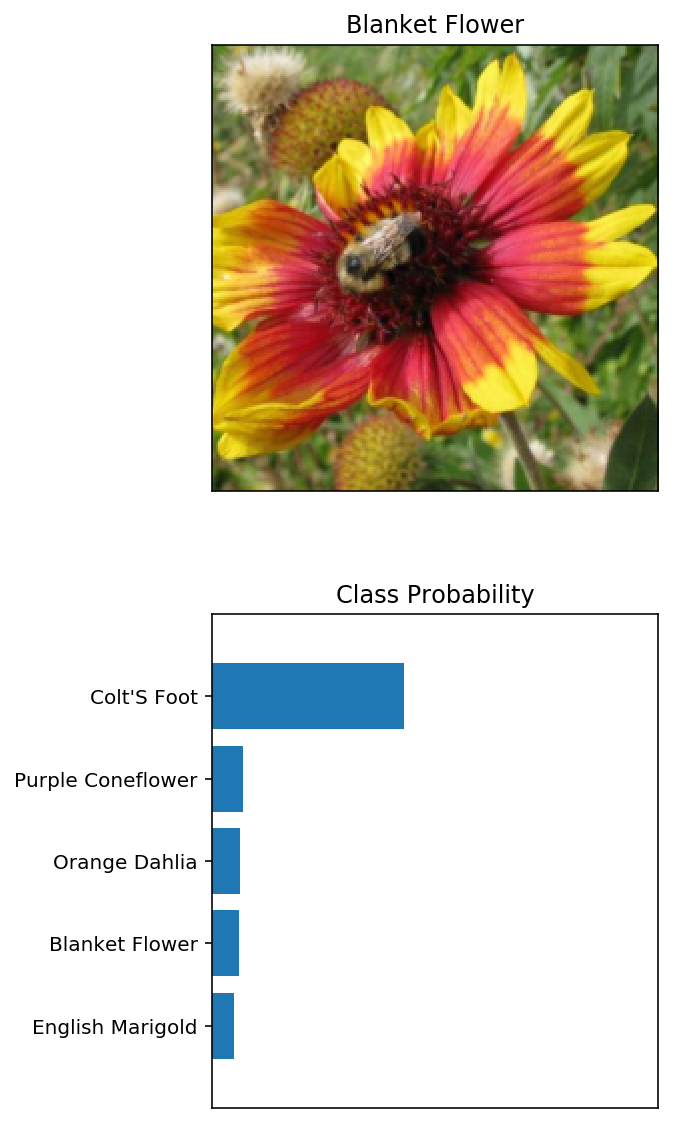

In [40]:
class_to_idx = image_datasets['test_data'].class_to_idx

cat_label_to_name = {}
for cat, label in class_to_idx.items():
    name = cat_to_name.get(cat)
    cat_label_to_name[label] = name
    

model_path = 'flower-image-classifier-checkpoint.pth' 
image_path = data_dir + '/test/100/image_07896.jpg'

probs, classes = predict(image_path, model)

probs = probs.data.cpu()
probs = probs.numpy().squeeze()

classes = classes.data.cpu()
classes = classes.numpy().squeeze()
classes = [cat_label_to_name[i].title() for i in classes]

label = class_to_idx[str(100)]
title = f'{cat_label_to_name[label].title()}'

fig = plt.figure(figsize=(4, 10))

ax1 = fig.add_subplot(2, 1, 1, xticks=[], yticks=[])
ax1.set_title(title)

image = Image.open(image_path)
image = process_image(image)
imshow(image, ax1, title)

ax2 = fig.add_subplot(2, 1, 2, xticks=[], yticks=[])
ax2.barh(np.arange(5), probs)
ax2.set_yticks(np.arange(5))
ax2.set_yticklabels(classes)
ax2.set_ylim(-1, 5)
ax2.invert_yaxis()
ax2.set_xlim(0, 1.1)
ax2.set_title('Class Probability')

plt.show()
    